# Import Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sent2vec.vectorizer import Vectorizer
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from scipy import spatial

from LambdaRankNN  import RankNetNN

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

In [4]:
df

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN


In [5]:
df.dtypes

id              int64
job_title      object
location       object
connection     object
fit           float64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [7]:
df.connection.unique()

array(['85', '500+ ', '44', '1', '61', '2', '390', '57', '82', '5', '7',
       '16', '212', '409', '52', '455', '174', '268', '50', '4', '40',
       '18', '349', '155', '39', '64', '9', '415', '19', '71', '48',
       '103', '49'], dtype=object)

In [8]:
df.location.unique()

array(['Houston, Texas', 'Kanada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'İzmir, Türkiye', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'Amerika Birleşik Devletleri', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massa

In [9]:
len(df.job_title.unique())

52

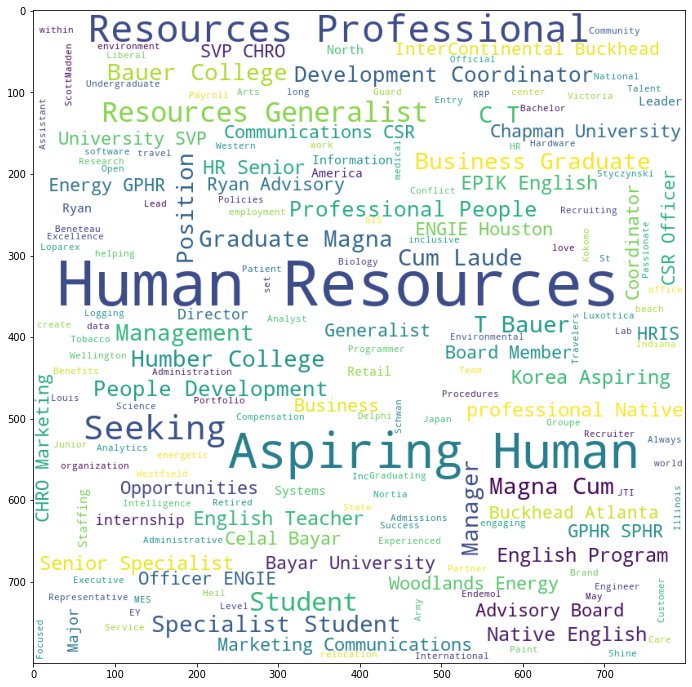

In [10]:
# Word Cloud plot for Job Title

word_cloud = df["job_title"]

plt.figure(figsize=(12,12))

wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=800,background_color="white").generate(' '.join(word_cloud))

plt.imshow(wc)

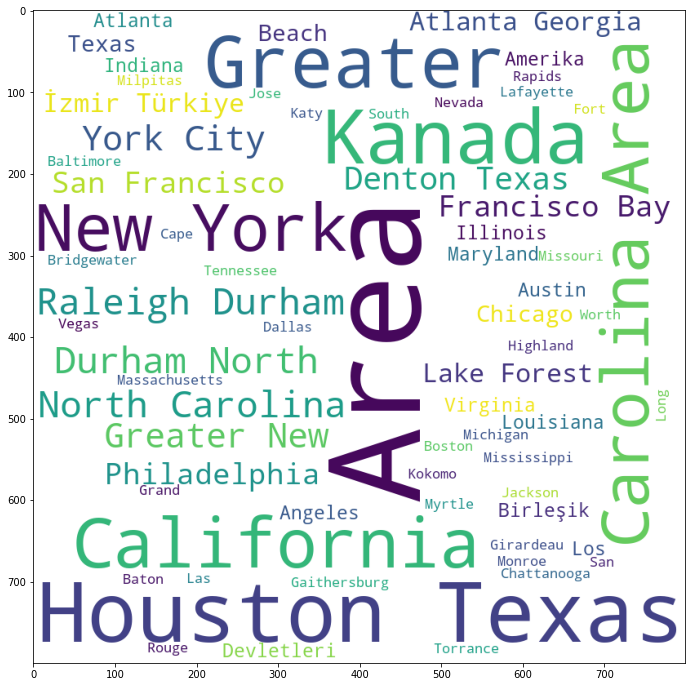

In [11]:
# Word Cloud plot for Job Title

word_cloud = df["location"]

plt.figure(figsize=(12,12))

wc = WordCloud(max_words=1000, min_font_size=10, 
                height=800,width=800,background_color="white").generate(' '.join(word_cloud))

plt.imshow(wc)

## Cleaning Job Title

To cleaning job title, we do the following:

* Split tokens on white space.
* Remove all punctuation from words.
* Remove all words that are not purely comprised of alphabetical characters.
* Remove all words that are known stop words

In [12]:
# Data cleaning and Preparation


def textpreprocessing(text):
    #remove punctuations and uppercase
    clean_text = re.sub('[^a-zA-Z]',' ', text)
    
    clean_text = clean_text.lower().split()
    
    #remove stopwords
    s_words =set(stopwords.words('english'))
    
    clean_text = [word for word in clean_text  if word not in s_words]
    
    sentence = []
    
    for word in clean_text:
        if word == 'hr':
            word = 'human resources'
        elif word == 'chro':
            word = 'chief human resources officer'
        elif word == 'gphr':
            word = 'general professional in human resources'
        elif word == 'sphr':
            word = 'senior professional in human resources'
        
        #lemmatize the word
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [13]:
df['cleaned_title'] = df['job_title'].apply(textpreprocessing)

In [14]:
df

,id,job_title,location,connection,fit,cleaned_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university
...,...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN,aspire human resources manager graduate may se...
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,human resources generalist loparex
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN,business intelligence analytics travelers
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN,always set success


In [15]:
df.cleaned_title.unique()

array(['c bauer college business graduate magna cum laude aspire human resources professional',
       'native english teacher epik english program korea',
       'aspire human resources professional',
       'people development coordinator ryan',
       'advisory board member celal bayar university',
       'aspire human resources specialist',
       'student humber college aspire human resources generalist',
       'human resources senior specialist',
       'seek human resources hris generalist position',
       'student chapman university',
       'svp chief human resources officer market communications csr officer engie houston woodlands energy general professional in human resources senior professional in human resources',
       'human resources coordinator intercontinental buckhead atlanta',
       'aspire human resources management student seek internship',
       'seek human resources opportunities',
       'experience retail manager aspire human resources professional',
    

# Generate Scores 

Similarity scores will be generated based on their similarity to the key phrases:

Aspiring human resources
Seeking human resources

This will be done by calculating the cosine similarity between vectorized job title and key phrases 

# TFIDF

Term Frequency-inverse document frequency (TF-idf): this looks at words that appear in both pieces of text, and scores them based on how often they appear. 

In [16]:
query1 = textpreprocessing('Aspiring human resources')
query2 = textpreprocessing('Seeking human resources')
query = [query1, query2]

In [17]:
tfvectorizer = TfidfVectorizer()

# TFIDF of job titles
title_vector = tfvectorizer.fit_transform(df.cleaned_title)

# TFIDF of job query
query_vector = tfvectorizer.transform(query)


In [18]:
tfidf_df = df.copy()

In [19]:
# Calculate TFIDF Cosine Similarity Scores of job titles to each job query

tfidf_df["tfidf_sim_1"]= cosine_similarity(title_vector, query_vector)[:,0]
tfidf_df["tfidf_sim_2"]= cosine_similarity(title_vector, query_vector)[:,1]

In [20]:
tfidf_df.sort_values(by='tfidf_sim_1', ascending=False).head(20)

,id,job_title,location,connection,fit,cleaned_title,tfidf_sim_1,tfidf_sim_2
45,46,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,NaN,aspire human resources professional,0.759450,0.291431
20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431
32,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431
57,58,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.677153,0.259851
48,49,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.677153,0.259851
59,60,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.677153,0.259851


In [21]:
# Calculate average of TFIDF Cosine Similarity Scores of job titles to querys

tfidf_df['tfidf_avg'] = tfidf_df.apply(lambda x: (x['tfidf_sim_1'] + x['tfidf_sim_2'])/2, axis=1)

In [22]:
tfidf_df.sort_values(by='tfidf_avg', ascending=False).head(20)

,id,job_title,location,connection,fit,cleaned_title,tfidf_sim_1,tfidf_sim_2,tfidf_avg
72,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,NaN,aspire human resources manager seek internship...,0.544969,0.596046,0.570508
45,46,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431,0.525441
32,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431,0.525441
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431,0.525441
20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431,0.525441
57,58,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431,0.525441
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,NaN,aspire human resources professional,0.759450,0.291431,0.525441
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.759450,0.291431,0.525441
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seek human resources position,0.267605,0.697360,0.482482
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.677153,0.259851,0.468502


# BERT

In [23]:
def cleaning_list(df, query1, query2):
    clean_list = []
    
    for num in range(len(df)):
        desc = df.iloc[num]['cleaned_title']
        
        desc = nltk.word_tokenize(desc)
        
        #removing words that are not in pretrained model.
        
        for word in range(len(desc)):
            if desc[word] in ['epik', 'celal', 'bayar', 'humber', 'engie', 'buckhead', 'luxottica', 'beneteau', 'scottmadden', 
                                'nortia', 'schwan', 'endemol', 'jti', 'styczynski', 'westfield', 'kokomo', 'delphi', 'loparex']:
                desc[word] = ''
        desc = ' '.join(desc)
        clean_list.append(desc)
    
    ## tokenize query and add to list
    clean_list.append(query1)
    clean_list.append(query2)
    
    return clean_list

In [24]:
cleaned_list = cleaning_list(df, query1, query2)

In [25]:
cleaned_list

['c bauer college business graduate magna cum laude aspire human resources professional',
 'native english teacher  english program korea',
 'aspire human resources professional',
 'people development coordinator ryan',
 'advisory board member   university',
 'aspire human resources specialist',
 'student  college aspire human resources generalist',
 'human resources senior specialist',
 'student  college aspire human resources generalist',
 'seek human resources hris generalist position',
 'student chapman university',
 'svp chief human resources officer market communications csr officer  houston woodlands energy general professional in human resources senior professional in human resources',
 'human resources coordinator intercontinental  atlanta',
 'c bauer college business graduate magna cum laude aspire human resources professional',
 'c bauer college business graduate magna cum laude aspire human resources professional',
 'native english teacher  english program korea',
 'aspire 

In [26]:
# vectorize cleaned job titles and query using Bert Model

vectorizer = Vectorizer()
vectorizer.run(cleaned_list)
bert_vectors = vectorizer.vectors

Initializing Bert distilbert-base-uncased
Vectorization done on cpu


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Cosine similarity

bert_scores1 = []
for num in range(len(cleaned_list) - 2):
    bert_scores1.append(1 - spatial.distance.cosine(bert_vectors[-2], bert_vectors[num]))
    
bert_scores2 = []
for num in range(len(cleaned_list) - 2):
    bert_scores2.append(1 - spatial.distance.cosine(bert_vectors[-1], bert_vectors[num]))
    


In [28]:
bert_df = df.copy()

bert_df['bert_fit1'] = bert_scores1
bert_df['bert_fit2'] = bert_scores2

In [30]:
bert_df['bert_fit_avg'] = bert_df.apply(lambda x: (x['bert_fit1'] + x['bert_fit2'])/2, axis=1)

In [31]:
bert_df.sort_values(by='bert_fit_avg', ascending=False).head(20)

,id,job_title,location,connection,fit,cleaned_title,bert_fit1,bert_fit2,bert_fit_avg
59,60,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.991878,0.990096,0.990987
23,24,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.991878,0.990096,0.990987
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.991878,0.990096,0.990987
48,49,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.991878,0.990096,0.990987
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.991878,0.990096,0.990987
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seek human resources opportunities,0.985240,0.996026,0.990633
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seek human resources opportunities,0.985240,0.996026,0.990633
67,68,Human Resources Specialist at Luxottica,Greater New York City Area,500+,NaN,human resources specialist luxottica,0.988010,0.992368,0.990189
77,78,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,NaN,human resources generalist schwan,0.988256,0.991175,0.989715
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,human resources generalist loparex,0.988256,0.991175,0.989715


# Word2vec

In [32]:
# vectorize cleaned job titles and query using Word2vec Model

vectorizer = Vectorizer(pretrained_weights= 'GoogleNews-vectors-negative300.bin')
vectorizer.run(cleaned_list)
word2vec_vectors = vectorizer.vectors

Initializing word2vec with vector path GoogleNews-vectors-negative300.bin


In [33]:
## Calculate cosine similarities 

w2v_scores1 = []
for num in range(len(cleaned_list) - 2):
    w2v_scores1.append(1 - spatial.distance.cosine(word2vec_vectors[-2], word2vec_vectors[num]))
    
w2v_scores2 = []
for num in range(len(cleaned_list) - 2):
    w2v_scores2.append(1 - spatial.distance.cosine(word2vec_vectors[-1], word2vec_vectors[num]))

In [34]:
w2v_df = df.copy()

w2v_df['w2v_fit1'] = w2v_scores1
w2v_df['w2v_fit2'] = w2v_scores2

In [35]:
w2v_df['w2v_fit_avg'] = w2v_df.apply(lambda x: (x['w2v_fit1'] + x['w2v_fit2'])/2, axis=1)

In [36]:
w2v_df.sort_values(by='w2v_fit_avg', ascending=False).head(10)

,id,job_title,location,connection,fit,cleaned_title,w2v_fit1,w2v_fit2,w2v_fit_avg
72,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,NaN,aspire human resources manager seek internship...,0.879637,0.852135,0.865886
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.914395,0.782766,0.848581
59,60,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.914395,0.782766,0.848581
48,49,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.914395,0.782766,0.848581
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.914395,0.782766,0.848581
23,24,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.914395,0.782766,0.848581
45,46,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.947545,0.749380,0.848462
16,17,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.947545,0.749380,0.848462
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.947545,0.749380,0.848462
20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.947545,0.749380,0.848462


# Glove

In [37]:
def glove_list(df):
    clean_list = []
    
    for num in range(len(df)):
        desc = df.iloc[num]['cleaned_title']
        
        desc = nltk.word_tokenize(desc)
        
        #removing words that are not in pretrained model.
        
        for word in range(len(desc)):
            if desc[word] in ['hris', 'epik', 'celal', 'bayar', 'humber', 'engie', 'buckhead', 'luxottica', 'beneteau', 'scottmadden', 
                                'nortia', 'schwan', 'endemol', 'jti', 'styczynski', 'westfield', 'kokomo', 'delphi', 'loparex']:
                desc[word] = ' '
                
        desc = ' '.join(desc)
        desc = nltk.word_tokenize(desc)
        clean_list.append(desc)
    
    
    return clean_list


In [38]:
def search_list(query):
    clean_list = []
    
    for num in range(len(query)):
        desc = query[num]
        
        desc = nltk.word_tokenize(desc)
    
        ## tokenize query and add to list
        clean_list.append(desc)
    
    return clean_list

In [39]:
gloveembed_list = glove_list(df)

In [40]:
glovesearch_list = search_list(query)

In [41]:
gloveembed_list

[['c',
  'bauer',
  'college',
  'business',
  'graduate',
  'magna',
  'cum',
  'laude',
  'aspire',
  'human',
  'resources',
  'professional'],
 ['native', 'english', 'teacher', 'english', 'program', 'korea'],
 ['aspire', 'human', 'resources', 'professional'],
 ['people', 'development', 'coordinator', 'ryan'],
 ['advisory', 'board', 'member', 'university'],
 ['aspire', 'human', 'resources', 'specialist'],
 ['student', 'college', 'aspire', 'human', 'resources', 'generalist'],
 ['human', 'resources', 'senior', 'specialist'],
 ['student', 'college', 'aspire', 'human', 'resources', 'generalist'],
 ['seek', 'human', 'resources', 'generalist', 'position'],
 ['student', 'chapman', 'university'],
 ['svp',
  'chief',
  'human',
  'resources',
  'officer',
  'market',
  'communications',
  'csr',
  'officer',
  'houston',
  'woodlands',
  'energy',
  'general',
  'professional',
  'in',
  'human',
  'resources',
  'senior',
  'professional',
  'in',
  'human',
  'resources'],
 ['human', 'reso

In [42]:
glovesearch_list

[['aspire', 'human', 'resources'], ['seek', 'human', 'resources']]

In [43]:
model = gensim.models.KeyedVectors.load_word2vec_format('glove.6B.300d.txt', no_header=True)

In [44]:
def get_vector(s):
    return np.sum(np.array([model[i] for i in s]), axis=0)

In [45]:
glove_vectors = []

for num in range(len(gloveembed_list)):
    glove_vectors.append(get_vector(gloveembed_list[num]))
    
glove_search_vector = []
for num in range(len(glovesearch_list)):
    glove_search_vector.append(get_vector(glovesearch_list[num]))

In [46]:
glove_scores1 = []
for num in range(len(gloveembed_list)):
    glove_scores1.append(1 - spatial.distance.cosine(glove_vectors[num], glove_search_vector[0]))
    
glove_scores2 = []
for num in range(len(gloveembed_list)):
    glove_scores2.append(1 - spatial.distance.cosine(glove_vectors[num], glove_search_vector[1]))

In [47]:

glove_df = df.copy()

glove_df['glove_fit1'] = glove_scores1
glove_df['glove_fit2'] = glove_scores2

In [48]:
glove_df['glove_fit_avg'] = glove_df.apply(lambda x: (x['glove_fit1'] + x['glove_fit2'])/2, axis=1)

In [49]:
glove_df.sort_values(by='glove_fit_avg', ascending=False).head(10)

,id,job_title,location,connection,fit,cleaned_title,glove_fit1,glove_fit2,glove_fit_avg
72,73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,NaN,aspire human resources manager seek internship...,0.899484,0.917465,0.908474
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.926265,0.850857,0.888561
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.926265,0.850857,0.888561
48,49,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.926265,0.850857,0.888561
59,60,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.926265,0.850857,0.888561
23,24,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,0.926265,0.850857,0.888561
29,30,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seek human resources opportunities,0.825153,0.950269,0.887711
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seek human resources opportunities,0.825153,0.950269,0.887711
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seek human resources position,0.819598,0.946998,0.883298
20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.913002,0.806942,0.859972


# Fuzzy Match

In [50]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [51]:
fuzzy_df = df.copy()

In [52]:
fuzzy_df

,id,job_title,location,connection,fit,cleaned_title
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,c bauer college business graduate magna cum la...
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university
...,...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN,aspire human resources manager graduate may se...
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,human resources generalist loparex
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN,business intelligence analytics travelers
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN,always set success


In [53]:
fuzzy_df['fuzzy_score1'] = fuzzy_df.apply(lambda x: fuzz.token_sort_ratio( x['cleaned_title'], query1), axis=1)
fuzzy_df['fuzzy_score2'] = fuzzy_df.apply(lambda x: fuzz.token_sort_ratio( x['cleaned_title'], query2), axis=1)

In [54]:
fuzzy_df['fuzzy_score_avg'] = fuzzy_df.apply(lambda x: (x['fuzzy_score1'] + x['fuzzy_score2'])/2, axis=1)

In [55]:
fuzzy_df.sort_values(by='fuzzy_score_avg', ascending=False).head(10)

,id,job_title,location,connection,fit,cleaned_title,fuzzy_score1,fuzzy_score2,fuzzy_score_avg
59,60,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,80,68,74.0
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,80,68,74.0
23,24,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,80,68,74.0
35,36,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,80,68,74.0
48,49,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspire human resources specialist,80,68,74.0
88,89,Director Human Resources at EY,Greater Atlanta Area,349,NaN,director human resources ey,78,64,71.0
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seek human resources position,59,82,70.5
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,NaN,aspire human resources professional,77,55,66.0
32,33,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,77,55,66.0
20,21,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,77,55,66.0



From the similarities score, the Glove Model performed the best.
This model score will be used in our Starred Ranking

# Starring


Starred job titles are added to the search phrases and used in the ranking.

In [56]:
glove_df

,id,job_title,location,connection,fit,cleaned_title,glove_fit1,glove_fit2,glove_fit_avg
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,c bauer college business graduate magna cum la...,0.510460,0.457787,0.484123
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik english program korea,0.297222,0.371722,0.334472
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resources professional,0.913002,0.806942,0.859972
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,0.492134,0.525044,0.508589
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,0.330511,0.417811,0.374161
...,...,...,...,...,...,...,...,...,...
99,100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN,aspire human resources manager graduate may se...,0.768883,0.815474,0.792178
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,human resources generalist loparex,0.804573,0.812580,0.808577
101,102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN,business intelligence analytics travelers,0.339344,0.409487,0.374415
102,103,Always set them up for Success,Greater Los Angeles Area,500+,NaN,always set success,0.417416,0.453061,0.435238


In [57]:
rankData = glove_df[['cleaned_title', 'glove_fit_avg']]

In [58]:
searchPhrase = ['aspiring human resources', 'seeking human resources']

def star_candidate():
    star_cand = []
    x = ''

    while x != 'done':
        x = ''
        while not x.isdigit():
            x = input('Specify best candidate by id, when finished type "done": ')
            if x == 'done':
                break

        star_cand.append(x)

    star_cand = star_cand[:-1]
    
    return star_cand

In [59]:
star_cand = star_candidate()

## subtract 1 from id to get index
star_cand = [int(i)-1 for i in star_cand]

star_cand

Specify best candidate by id, when finished type "done": 30
Specify best candidate by id, when finished type "done": 29
Specify best candidate by id, when finished type "done": done


[29, 28]

In [60]:
for i in star_cand :
    searchPhrase.append(rankData['cleaned_title'][i])

In [61]:
glovesearch_list = search_list(searchPhrase)

In [62]:
glove_search_vector = []
for num in range(len(glovesearch_list)):
    glove_search_vector.append(get_vector(glovesearch_list[num]))

In [63]:
# Calculate Cosine Similarity Between jobTitleVectors and new search Phrase vectors

# Initialize Arrays
gloveScore = np.zeros(len(glove_vectors))

# Loop through and add up scores for all search phrases
for i in range(len(glove_vectors)) :
    for j in range(len(glove_search_vector)) :
        gloveScore[i] += (1 - spatial.distance.cosine(glove_vectors[i], glove_search_vector[j]))
        

# Assign score for each vector group as average of scores for each search vector
rankData['glove_starred'] = gloveScore/len(glove_search_vector)

/var/folders/84/c_54071n7rxgl7py65404n900000gn/T/ipykernel_39894/661380678.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankData['glove_starred'] = gloveScore/len(glove_search_vector)


In [65]:
rankData.sort_values(by='glove_starred', ascending=False).head(10)

,cleaned_title,glove_fit_avg,glove_starred
29,seek human resources opportunities,0.887711,0.898121
27,seek human resources opportunities,0.887711,0.898121
72,aspire human resources manager seek internship...,0.908474,0.893319
98,seek human resources position,0.883298,0.859854
28,aspire human resources management student seek...,0.799645,0.842624
26,aspire human resources management student seek...,0.799645,0.842624
73,human resources professional,0.841388,0.835941
23,aspire human resources specialist,0.888561,0.822426
59,aspire human resources specialist,0.888561,0.822426
35,aspire human resources specialist,0.888561,0.822426


# Ranknet

In [66]:
star_cand = star_candidate()
star_cand = [int(i)-1 for i in star_cand]

Specify best candidate by id, when finished type "done": 30
Specify best candidate by id, when finished type "done": 29
Specify best candidate by id, when finished type "done": done


In [67]:
star_cand

[29, 28]

In [68]:
rankData['star_score'] = rankData['glove_fit_avg']
rankData.iloc[star_cand,[3]] = 1
rankData.iloc[star_cand]

/var/folders/84/c_54071n7rxgl7py65404n900000gn/T/ipykernel_39894/2502840440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankData['star_score'] = rankData['glove_fit_avg']
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,cleaned_title,glove_fit_avg,glove_starred,star_score
29,seek human resources opportunities,0.887711,0.898121,1.0
28,aspire human resources management student seek...,0.799645,0.842624,1.0


In [69]:
X = pd.DataFrame(glove_vectors)
y = np.array(rankData['star_score'])

X['qid'] = 1

qid = np.array(X['qid'])

X.drop('qid', axis=1, inplace=True)

X = X.to_numpy()

In [70]:
ranker = RankNetNN(input_size=X.shape[1], hidden_layer_sizes=(128, 64,), activation=('relu', 'relu',))

ranker.fit(X, y, qid, epochs=35)

Epoch 1/35
  1/163 [..............................] - ETA: 26s - loss: 0.8424

2022-09-12 22:12:28.136253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-12 22:12:28.140742: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


163/163 [==============================] - 0s 552us/step - loss: 0.1539
Epoch 2/35
163/163 [==============================] - 0s 539us/step - loss: 0.0767
Epoch 3/35
163/163 [==============================] - 0s 536us/step - loss: 0.0684
Epoch 4/35
163/163 [==============================] - 0s 532us/step - loss: 0.0591
Epoch 5/35
163/163 [==============================] - 0s 535us/step - loss: 0.0555
Epoch 6/35
163/163 [==============================] - 0s 535us/step - loss: 0.0530
Epoch 7/35
163/163 [==============================] - 0s 544us/step - loss: 0.0541
Epoch 8/35
163/163 [==============================] - 0s 535us/step - loss: 0.0478
Epoch 9/35
163/163 [==============================] - 0s 599us/step - loss: 0.0504
Epoch 10/35
163/163 [==============================] - 0s 530us/step - loss: 0.0444
Epoch 11/35
163/163 [==============================] - 0s 530us/step - loss: 0.0434
Epoch 12/35
163/163 [==============================] - 0s 534us/step - loss: 0.0440
Epoch 13/35


In [71]:
pred = ranker.predict(X)

## normalize predictions between 0 and 1
norm_pred = (pred - np.min(pred)) / (np.max(pred) - np.min(pred))

In [72]:
rankData['ranknet_fit'] = norm_pred
rankData.sort_values('ranknet_fit', ascending=False).head(15)

/var/folders/84/c_54071n7rxgl7py65404n900000gn/T/ipykernel_39894/73676753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rankData['ranknet_fit'] = norm_pred


,cleaned_title,glove_fit_avg,glove_starred,star_score,ranknet_fit
72,aspire human resources manager seek internship...,0.908474,0.893319,0.908474,1.000000
29,seek human resources opportunities,0.887711,0.898121,1.000000,0.981287
27,seek human resources opportunities,0.887711,0.898121,0.887711,0.981287
35,aspire human resources specialist,0.888561,0.822426,0.888561,0.965621
5,aspire human resources specialist,0.888561,0.822426,0.888561,0.965621
48,aspire human resources specialist,0.888561,0.822426,0.888561,0.965621
59,aspire human resources specialist,0.888561,0.822426,0.888561,0.965621
23,aspire human resources specialist,0.888561,0.822426,0.888561,0.965621
98,seek human resources position,0.883298,0.859854,0.883298,0.958029
20,aspire human resources professional,0.859972,0.810098,0.859972,0.951200
